# 1. Importing essential libraries



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow import keras
import pandas as pd
import matplotlib.pylab as plt
import tensorflow_hub as hub
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


# 2.Augmenting the data and dividing into train and valid

In [2]:
data_path ="Datasets/train"
dir_Path = str(data_path)
image_size = (224,224)
datagen_args = dict(rescale=1./255,
                    validation_split=.30,
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    )
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_args)
valid_generator = valid_datagen.flow_from_directory(
                                            dir_Path, 
                                            subset="validation", 
                                            shuffle=True,
                                            class_mode = 'categorical',
                                            target_size=image_size
                                        )
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_args)
train_generator = train_datagen.flow_from_directory(
    dir_Path, 
    subset="training", 
    shuffle=True,
    class_mode = 'categorical',
    target_size=image_size)

Found 8787 images belonging to 37 classes.
Found 20556 images belonging to 37 classes.


In [20]:
train_generator.num_classes

37

# 3. MobileNet_V2 transfer learning

In [21]:
feature_extractor = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [22]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(224,224,3))


In [23]:
feature_extractor_layer.trainable = False


In [24]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(train_generator.num_classes,activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 37)                47397     
Total params: 2,305,381
Trainable params: 47,397
Non-trainable params: 2,257,984
_________________________________________________________________


# 4. Compiling the data and training the data on our model for 10 epochs.

In [25]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['acc']
                )

In [26]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
 
hist = model.fit(
                train_generator, 
                epochs=10,
                verbose=1,
                steps_per_epoch=steps_per_epoch,
                validation_data=valid_generator,
                validation_steps=val_steps_per_epoch).history

Epoch 1/10
734/734 [==============================] - 1149s 2s/step - loss: 0.8843 - acc: 0.7443 - val_loss: 0.4001 - val_acc: 0.8762
Epoch 2/10
734/734 [==============================] - 1187s 2s/step - loss: 0.4059 - acc: 0.8731 - val_loss: 0.3004 - val_acc: 0.9028
Epoch 3/10
734/734 [==============================] - 992s 1s/step - loss: 0.3400 - acc: 0.8899 - val_loss: 0.2852 - val_acc: 0.9040
Epoch 4/10
734/734 [==============================] - 1030s 1s/step - loss: 0.3092 - acc: 0.8968 - val_loss: 0.2638 - val_acc: 0.9137
Epoch 5/10
734/734 [==============================] - 943s 1s/step - loss: 0.2951 - acc: 0.9021 - val_loss: 0.2344 - val_acc: 0.9231
Epoch 6/10
734/734 [==============================] - 1222s 2s/step - loss: 0.2883 - acc: 0.9039 - val_loss: 0.2601 - val_acc: 0.9148
Epoch 7/10
734/734 [==============================] - 1249s 2s/step - loss: 0.2716 - acc: 0.9085 - val_loss: 0.2328 - val_acc: 0.9204
Epoch 8/10
734/734 [==============================] - 1168s 2s/s

In [27]:
result=model.evaluate(valid_generator)


183/183 [==============================] - 183s 998ms/step - loss: 0.2321 - acc: 0.9189


In [3]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)
print(len(dataset_labels))

['Ants Damage To Banana Fruits' 'Apple___Apple_Scab' 'Apple___Black_Rot'
 'Apple___Cedar_Apple_Rust' 'Apple___Healthy' 'Black Spot Of Papaya'
 'Black Spot Of Papaya Leaf' 'Black Spots Of Papaya'
 'Cherry_(Including_Sour)___Powdery_Mildew'
 'Cherry_(Including_Sour)___Healthy'
 'Corn_(Maize)___Cercospora_Leaf_Spot Gray_Leaf_Spot'
 'Corn_(Maize)___Common_Rust_' 'Corn_(Maize)___Northern_Leaf_Blight'
 'Corn_(Maize)___Healthy' 'Grape___Black_Rot' 'Grape___Esca_Black_Measles'
 'Grape___Leaf_Blight_Isariopsis_Leaf_Spot' 'Grape___Healthy'
 'Mango_Anthracose' 'Mango_Bacterial_Canker_Disease'
 'Papaya Fruit Anthracnose' 'Papaya Fruit Powdery Mildew'
 'Papaya Leaf Powdery Mildew' 'Pepper,_Bell___Bacterial_Spot'
 'Pepper,_Bell___Healthy' 'Strawberry___Leaf_Scorch'
 'Strawberry___Healthy' 'Tomato___Bacterial_Spot' 'Tomato___Early_Blight'
 'Tomato___Late_Blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_Leaf_Spot'
 'Tomato___Spider_Mites Two-Spotted_Spider_Mite' 'Tomato___Target_Spot'
 'Tomato___Tomato

In [29]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

183/183 [==============================] - 188s 1s/step - loss: 0.2324 - acc: 0.9243
Final loss: 0.23
Final accuracy: 92.43%


# 5. Saving the model

In [64]:
model.save('./models')


INFO:tensorflow:Assets written to: ./models\assets


INFO:tensorflow:Assets written to: ./models\assets


# 6. Plotting validation and training accuracies and losses

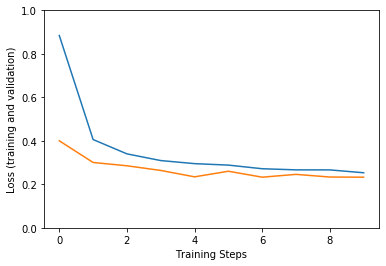

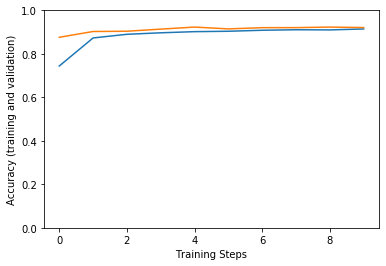

In [32]:
import matplotlib.pyplot as plt

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [43]:
model.save("fruitdiseasemodel.h5")

In [47]:
# saved_model_path = "/saved_model/fruit_model.h5" # or you can simply use 'my_mode.h5'
# model.save(saved_model_path) #save your model 

# # to reload your model 
# model = keras.models.load_model(saved_model_path)

FRUITS_SAVED_MODEL = "saved_models/fruits"
tf.saved_model.save(model, FRUITS_SAVED_MODEL)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: saved_models/fruits\assets


INFO:tensorflow:Assets written to: saved_models/fruits\assets


# 7. Loading the model

In [4]:
FRUITS_SAVED_MODEL = "saved_models/fruits"
fruits_model = hub.load(FRUITS_SAVED_MODEL)
print(fruits_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x000002D0296A70C8>


# 8. Predictions valid on Images

In [10]:
# Get images and labels batch from validation dataset generator
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)
# >> Validation batch shape: (32, 224, 224, 3)

# Get predictions for images batch
tf_model_predictions = fruits_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)
# >> Prediction results shape: (32, 5)


Validation batch shape: (32, 224, 224, 3)
Prediction results shape: (32, 37)


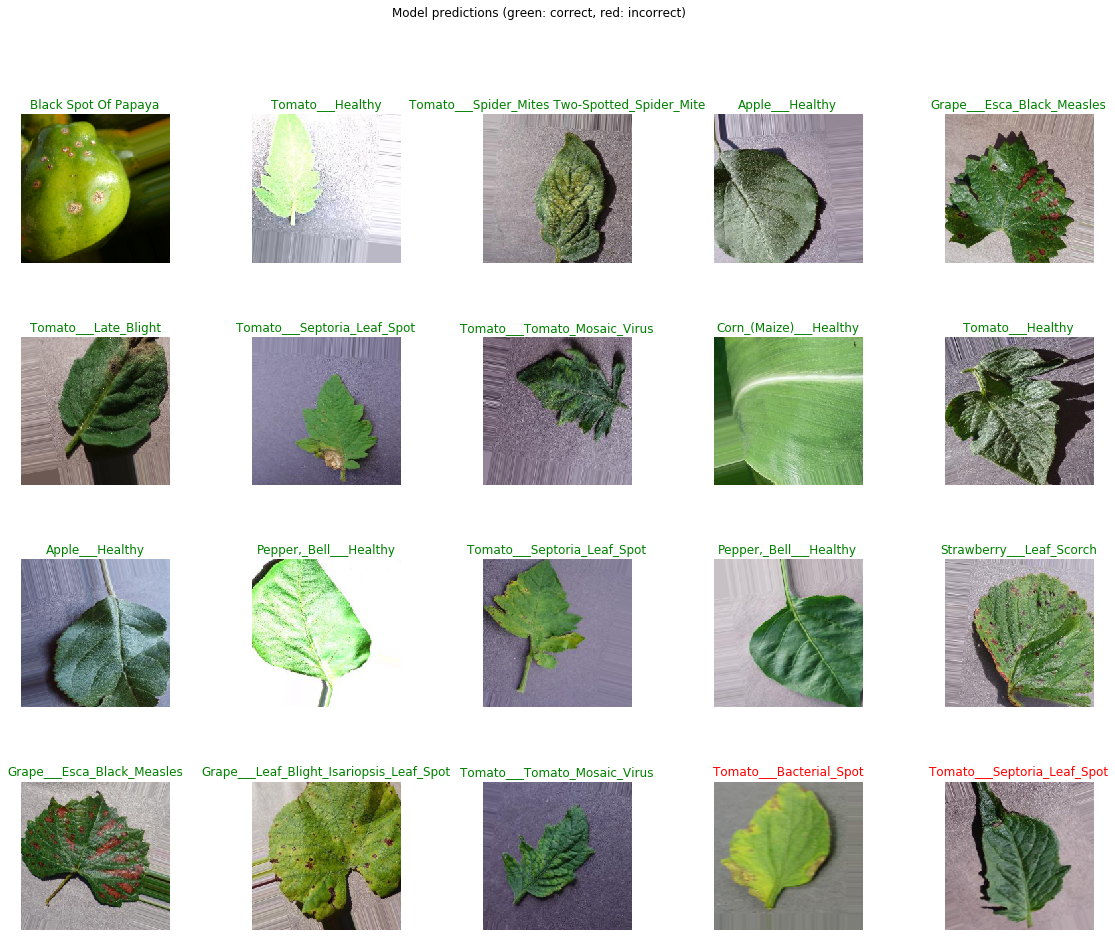

In [11]:
# Get predictions for each image
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

# Print images batch and labels predictions
plt.figure(figsize=(20,15))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
    plt.subplot(4,5,n+1)
    plt.imshow(val_image_batch[n])
    color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
    plt.title(predicted_labels[n].title(), color=color)
    plt.axis('off')
    plt.suptitle("Model predictions (green: correct, red: incorrect)")

# 9. Converting our SavedModel Format model into Tensorlite model

In [54]:
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/fruits.tflite"

# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : fruits_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

A subdirectory or file tflite_models already exists.


9159304

# 10. Adding Metadata to TFLITE model

In [57]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils
from tflite_support import metadata

ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = "tflite_models/fruits.tflite"
_LABEL_FILE = "labels.txt"
_SAVE_TO_PATH = "fruitsmetadata.tflite"

_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba

In [55]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [59]:
def predictions(test_images):
    y_pred = model.predict(test_images,steps = 1)
    predicted_img = []
    for i in  range(len(test_images)):
        predicted_img.append( np.argmax(y_pred[i]))
    
    
    return predicted_img
    
def labels(test_labels):  
    rounded_labels = []
    for i in range(len(test_labels)):
        count = 0
        for j in range(30):
            if test_labels[i][j] == 0:
                count += 1
            else:
                break
        rounded_labels.append(count)
    return rounded_labels

In [60]:
predicted_img = predictions(val_image_batch)
predicted_img_labels = labels(val_label_batch)

In [61]:
cm = confusion_matrix(  predicted_img, predicted_img_labels)
cm

array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

In [62]:
print(classification_report(predicted_img, predicted_img_labels))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         3
          23       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         1
          27       1.00      1.00      1.00         5
          29       0.00      0.00      0.00         0
          30       0.00      0.00      0.00         1
          31       0.00      0.00      0.00         1
          33       0.00    

C:\py.anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\py.anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


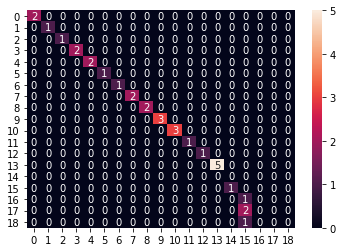

In [63]:
sns.heatmap(cm, annot = True)